<a href="https://colab.research.google.com/github/DhruvPatel1409/Deep-Learning/blob/main/LSTM_IMDB_Sentiment_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is this?

This Jupyter Notebook contains Python code for building a LSTM Recurrent Neural Network that gives 87-88% accuracy on the IMDB Movie Review Sentiment Analysis Dataset.

More information is given on [this blogpost](https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks).

This code is supplied without license, warranty or support. Feel free to do with it what you will.

## Built for Google Collaboratory

Train your network more quickly in Google Collaboratory. From the **Runtime** menu select **Change Runtime** Type and choose "GPU"!

Don't forget to select **Runtime** -> **Restart runtime** to put your changes into effect.

## Setting up

When running this for the first time you may get a warning telling you to restart the Runtime. You can ignore this, but feel free to select "Runtime->Restart Runtime" from the overhead menu if you encounter problems.

In [1]:
# keras.datasets.imdb is broken in TensorFlow 1.13 and 1.14 due to numpy 1.16.3

# All the imports!
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "IMDB Movie Review" data, constraining our reviews to
# the 10000 most commonly used words
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Map for readable classnames
class_names = ["Negative", "Positive"]

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Create map for converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also
contains an index for converting the reviews back into human readable form.

In [2]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our review look like in machine and human readable form?


In [3]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> 

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [5]:
# The length of reviews
review_length = 500

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should
# contain 25000 reviews of 500 integers. Class data should contain 25000 values,
# one for each review. Class values are 0 or 1, indicating a negative
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (25000, 500)
Shape Training Class Data: (25000,)
Shape Test Review Data: (25000, 500)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

## Create and build LSTM Recurrent Neural Network

In [16]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Model

# Define the input layer
inputs = Input(shape=(review_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=32)(inputs)

# Dropout layer
dropout_layer1 = Dropout(0.25)(embedding_layer)

# LSTM layer
lstm_layer = LSTM(32)(dropout_layer1)

# Dropout layer
dropout_layer2 = Dropout(0.25)(lstm_layer)

# Dense layer with sigmoid activation
output_layer = Dense(1, activation='sigmoid')(dropout_layer2)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display a summary of the model's structure
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 500, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,353 (1.25 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

## Visualise the Model

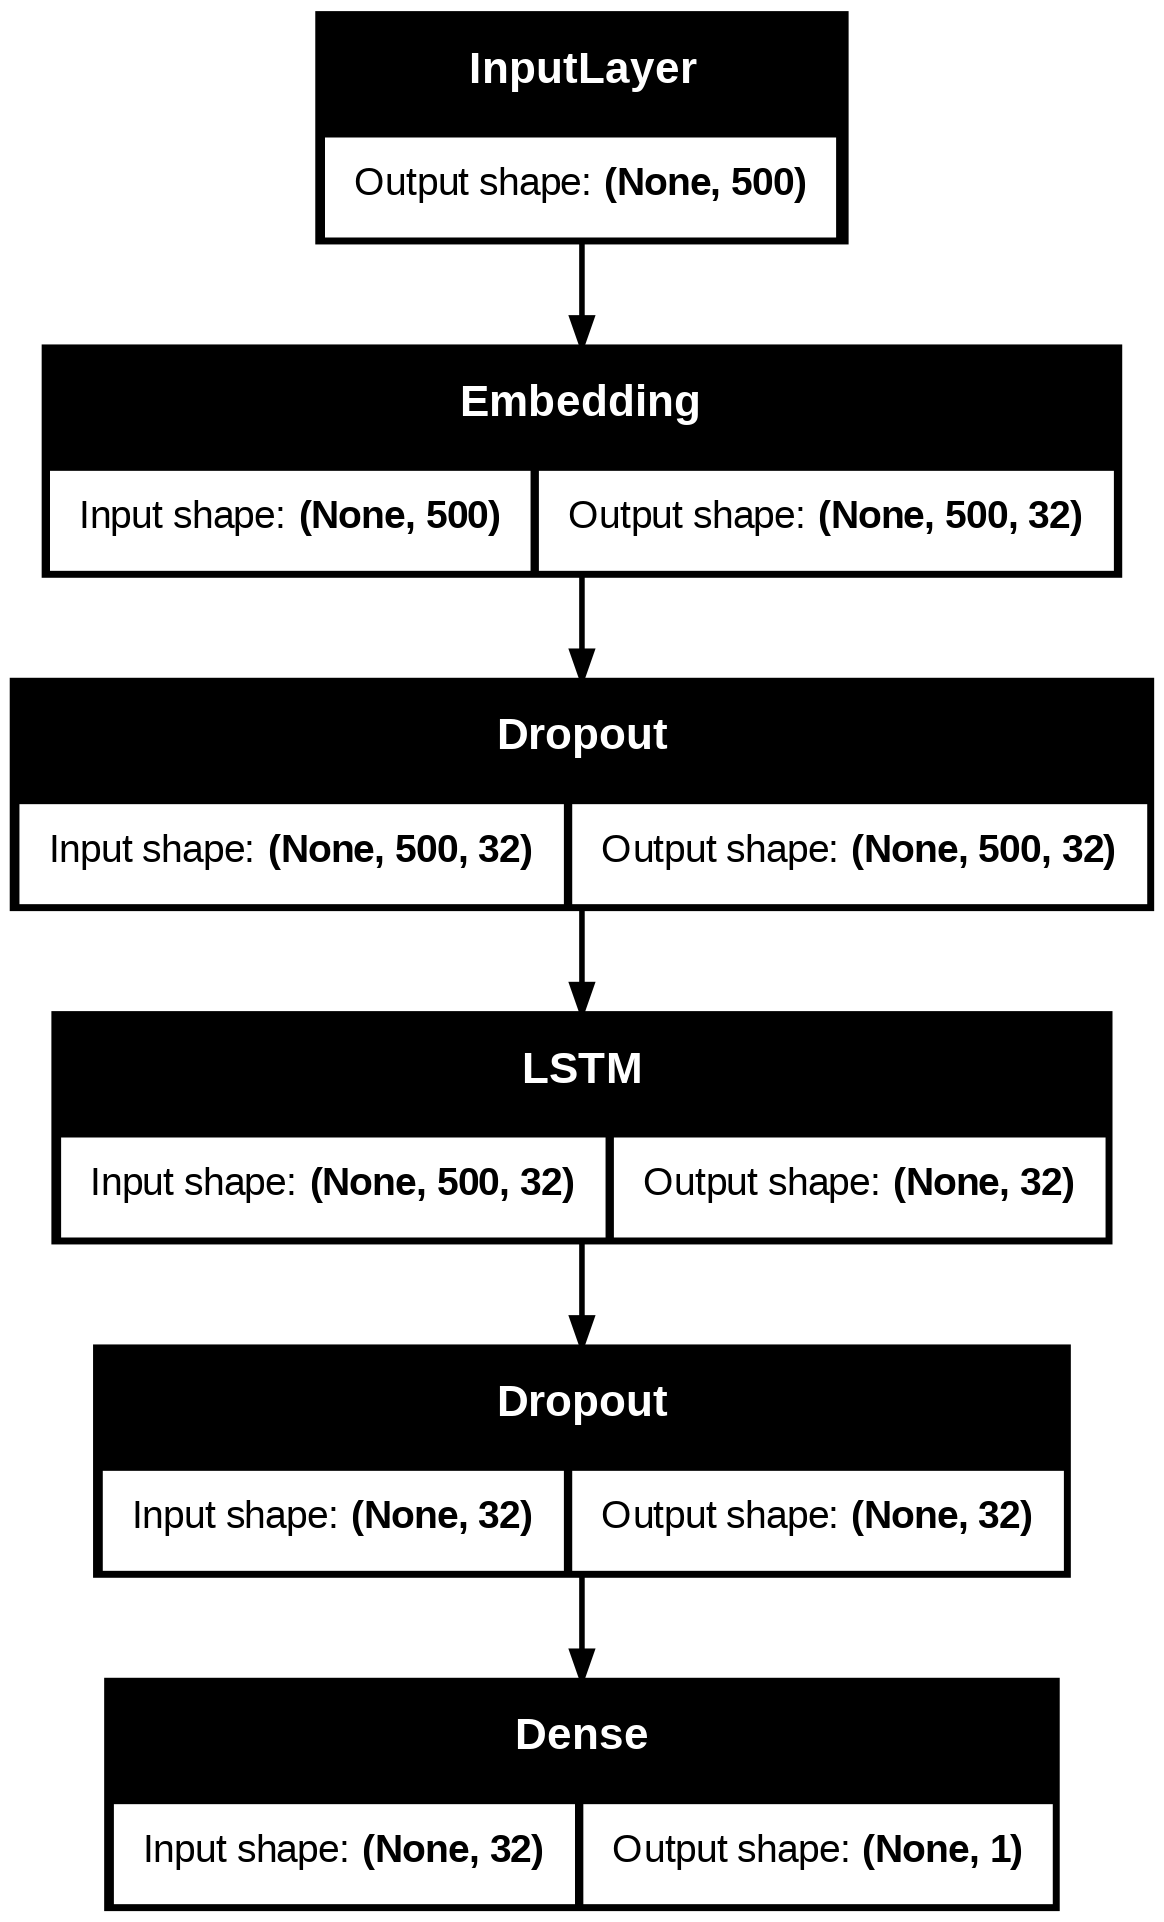

In [17]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

In [18]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,

    # Number of samples to work through before updating the
    # internal model parameters via back propagation. The
    # higher the batch, the more memory you need.
    batch_size=256,

    # An epoch is an iteration over the entire training data.
    epochs=3,

    # The model will set apart his fraction of the training
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of
    # each epoch.
    validation_split=0.2,

    verbose=1
)

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5561 - loss: 0.6845 - val_accuracy: 0.7068 - val_loss: 0.5941
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7590 - loss: 0.5159 - val_accuracy: 0.8276 - val_loss: 0.4003
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8745 - loss: 0.3121 - val_accuracy: 0.8492 - val_loss: 0.3574


## Evaluate model with test data and view results

In [20]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
predicted_probs = model.predict(x_test)
predicted_classes = np.argmax(predicted_probs, axis=1)

print(classification_report(y_test, predicted_classes, target_names=class_names))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67     12500
    Positive       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## View some incorrect predictions

Lets have a look at some of the incorrectly classified reviews. For readability we remove the padding.



In [21]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):

    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])

    print("Incorrectly classified Test Review ["+ str(j+1) +"]")
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #1: Predicted [Negative] Actual [Positive]
Test Review Text: <START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances <UNKNOWN> the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere <UNKNOWN> with sexual tension and psychological <UNKNOWN> it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the <UNKNOWN> moody set fits the content

## Run your own text against the trained model

This is a fun way to test out the limits of the trained model. To avoid getting errors - type in lower case only and do not use punctuation!

You'll see the raw prediction from the model - basically a value between 0 and 1.



In [22]:
# Write your own review
review = "this was a terrible film with too much sex and violence i walked out halfway through"
#review = "this is the best film i have ever seen it is great and fantastic and i loved it"
#review = "this was an awful film that i will never see again"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Ensure review is 500 words long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length)

# Run your processed review against the trained model
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Review: this was a terrible film with too much sex and violence i walked out halfway through
Raw Prediction: 0.04125171
Predicted Class: Negative
